## Import Data

In [1]:
#Import packages
import pandas as pd
%pylab inline
import datetime
from datetime import datetime
import time
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Test Run with only the first 10,000 rows of the dataset one (9 others remaining)
# Need more computational power to concat all 10 datasets and run
data = pd.read_csv('IRAhandle_tweets_1.csv')[:10000]

In [3]:
# Drop some columns
data = data[data['language'] == 'English'].drop(['following','harvested_date','account_type','post_type','language','tco1_step1','tco2_step1','tco3_step1','external_author_id','alt_external_id','region','new_june_2018','tweet_id','article_url'],axis=1)
data.head(5)

,author,content,publish_date,followers,updates,retweet,account_category
0,10_GOP,"""We have a sitting Democrat US Senator on tria...",10/1/17 19:58,9636,253,0,RightTroll
1,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,10/1/17 22:43,9637,254,0,RightTroll
2,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,10/1/17 22:50,9637,255,1,RightTroll
3,10_GOP,JUST IN: President Trump dedicates Presidents ...,10/1/17 23:52,9642,256,0,RightTroll
4,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",10/1/17 2:13,9645,246,1,RightTroll


## Data Exploring

In [8]:
# Top 20 Authors involved with Russian Trolls with most followers 
data[['author','account_category','followers']].groupby(['author','account_category']).sum().sort_values(by=['followers'],ascending=False)[0:20]

,,followers
author,account_category,
ANDYHASHTAGGER,HashtagGamer,184462698
ATLANTA_ONLINE,NewsFeed,141509452
AMELIEBALDWIN,RightTroll,85521549
AMANDAVGREEN,HashtagGamer,14233097
ALECMOOOOODY,LeftTroll,7054474
ANTONHAYHAY,LeftTroll,6965162
ANNIEPOSHES,HashtagGamer,6273115
4MYSQUAD,LeftTroll,5555732
ADRIENNE_GG,HashtagGamer,5373765


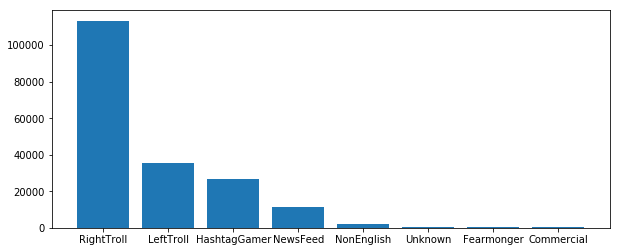

In [9]:
# Account category distribution
plt.figure(figsize=(10,4))
plt.bar(data['account_category'].value_counts().index, data['account_category'].value_counts().values)
plt.show()

In [10]:
# What category of trolls get the most updates?
data[['account_category','updates']].groupby(['account_category']).sum().sort_values(['updates'], ascending=False)

,updates
account_category,
RightTroll,905766560
LeftTroll,149916375
HashtagGamer,119631323
NewsFeed,76405859
NonEnglish,15883304
Unknown,165611
Fearmonger,155184
Commercial,70718


In [11]:
# Transform and build a datetime dataframe named date
data['date'] = pd.to_datetime(data['publish_date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

date = data[['year','month','day']].sort_values(by= 'year',ascending=True)
date['y-m'] = date['year'] * 100 + date['month']

In [12]:
# Top 20 most frequent publish_time
pd.DataFrame(data['date'].value_counts()[:20])

,date
2017-08-15 17:10:00,82
2017-08-12 19:16:00,74
2017-08-16 14:09:00,69
2017-08-15 17:09:00,69
2017-08-12 19:11:00,67
2017-08-12 18:26:00,65
2017-08-15 17:01:00,63
2017-08-18 06:19:00,61
2017-08-12 19:09:00,61
2017-08-18 06:14:00,59


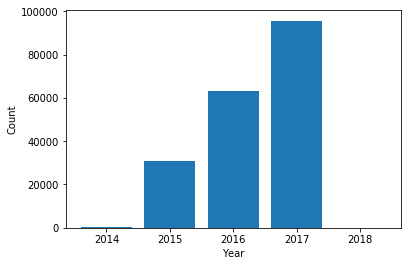

In [13]:
# Plot the number of trolls by year
plt.bar(date['year'].value_counts().index,date['year'].value_counts().values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

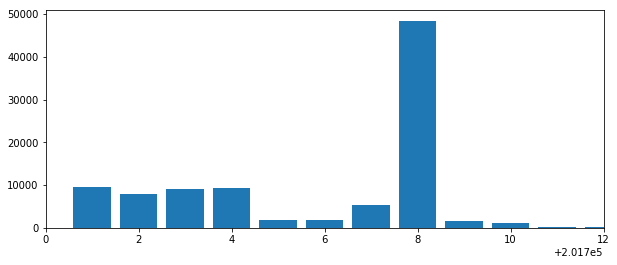

In [14]:
# Distribution in Yr 2017
plt.figure(figsize=(10,4))
plt.xlim(201700, 201712)
plt.bar(date['y-m'].value_counts().index,date['y-m'].value_counts().values)
plt.show()

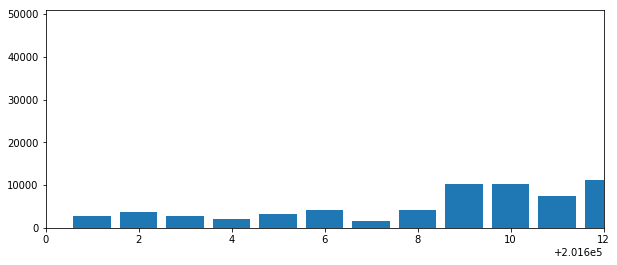

In [15]:
# Distribution in Yr 2016
plt.figure(figsize=(10,4))
plt.xlim(201600, 201612)
plt.bar(date['y-m'].value_counts().index,date['y-m'].value_counts().values)
plt.show()

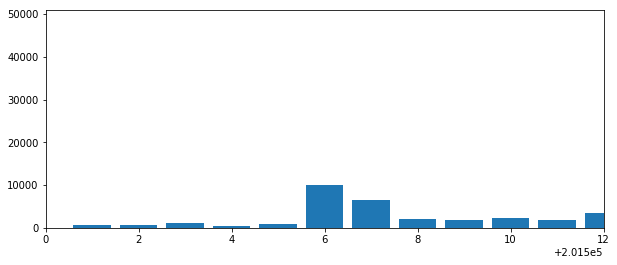

In [16]:
# Distribution in Yr 2015
plt.figure(figsize=(10,4))
plt.xlim(201500, 201512)
plt.bar(date['y-m'].value_counts().index,date['y-m'].value_counts().values)
plt.show()

## Word Frequency Analysis

In [4]:
#Remove punctuation & change everything to lowercase
def lower_text(s):
    for p in punctuation:
        s = s.replace(p,'')
    return s.lower()

data['content'] = data['content'].map(lower_text)

#Remove stopwords
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.extend((',','""','u','ya'))
def stop(string):
    string = " "+string+" "
    for word in stopwords:
        string = string.replace(" "+str(word)+" ", ' ') 
    return string

data['no_stop'] = data['content'].map(stop) 

#Tokenizing & Lemmatizing 
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_stem_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

data['Lemmatize'] = data['no_stop'].apply(lemmatize_stem_text).str.join(' ')

#Part of Speech Tag
def tokenize(s):
    return nltk.pos_tag(word_tokenize(s))

data['Tokens'] = data['Lemmatize'].map(tokenize)

# Make Tokened words in a list
token_list = list()
for items in data['Tokens']:
    token_list = token_list + items
    
# Find NN  -- Nouns 
def takeNN(X):
    NNwords =[]
    for word,tag in X:
        if tag == 'NN':
            NNwords.append(word)
    return NNwords

In [135]:
# Get Top 20 Nouns in content
top_NN = pd.Series(takeNN(token_list))
top_NN.value_counts()[:20]

blacklivesmatter      918
cop                   623
policebrutality       567
blacktwitter          326
police                252
blm                   241
acab                  211
racism                195
man                   194
officer               144
deray                 121
trump                 116
policeviolence        110
woman                 109
time                  104
policestate            99
blackpeopletwitter     96
justice                95
video                  92
year                   87
dtype: int64

## Lift Ratio

In [136]:
# adding in fake data to make sure there are no zeros
top = top_NN.value_counts()[:20].index.values.tolist()
comments= data['content'].tolist()
dflift = pd.DataFrame(index = top, columns = top)

#count of both words
def twowordcount (word1, word2, clist):
    count =0
    for eachcomment in clist:
        if eachcomment.count(word1) != 0 and eachcomment.count(word2) != 0:
            count += 1
    return count 

#count of each individual word
def singlewordcount(word, clist):
    count =0 
    for eachcomment in clist:
        if eachcomment.count(word) != 0:
            count += 1
    return count

#calculates lift 
def liftratio(word1, word2, clist):
    numerator  = twowordcount(word1, word2, clist)*len(clist)
    denominator = singlewordcount(word1, clist)*singlewordcount(word2, clist)
    lift= float(numerator)/denominator
    return lift


#Calculate the lift ratio between each word and each other word.  Store it in a dataframe called dflist
for eachbrand in top:
    top = [word for word in top if word != eachbrand]
    for j in range(len(top)):
        dflift[top[j]].loc[eachbrand]=liftratio(top[j], eachbrand, comments)
        dflift[eachbrand].loc[top[j]] = dflift[top[j]][eachbrand]
    
dflift

,blacklivesmatter,cop,policebrutality,blacktwitter,police,blm,acab,racism,man,officer,deray,trump,policeviolence,woman,time,policestate,blackpeopletwitter,justice,video,year
blacklivesmatter,NaN,1.81021,2.72193,3.68828,2.05617,1.93659,2.3893,3.02158,0.829345,0.77292,0.936458,0.0713733,3.09284,0.960295,0.893813,1.433,4.10223,1.95508,0.776709,0.848832
cop,1.81021,NaN,3.61225,1.90332,2.74543,2.10995,4.17937,1.42876,1.62708,1.70279,0.198055,0.0754752,3.52217,2.1035,1.16,3.59355,1.68097,1.17258,2.1355,1.64563
policebrutality,2.72193,3.61225,NaN,3.41407,5.01407,3.10795,5.18107,2.71514,1.22495,2.94769,0.258756,0.0410863,7.06685,1.65839,0.841953,4.52523,3.18798,1.31022,1.52019,0.651511
blacktwitter,3.68828,1.90332,3.41407,NaN,2.31095,2.26717,4.41811,3.40269,0.740339,1.27453,0.423551,0.067253,2.1521,1.16339,0.114847,0.578689,6.37794,1.31979,0.585497,0.666525
police,2.05617,2.74543,5.01407,2.31095,NaN,2.24705,3.90552,1.8657,1.42963,3.66883,0.46229,0.0451718,5.01407,1.56283,1.15709,5.01407,2.14193,1.302,2.40872,1.52213
blm,1.93659,2.10995,3.10795,2.26717,2.24705,NaN,3.16471,2.48605,0.85893,2.17276,0.421198,0,3.74525,1.02838,1.06595,0.767298,2.30636,1.53121,1.55265,1.06052
acab,2.3893,4.17937,5.18107,4.41811,3.90552,3.16471,NaN,1.69119,1.38981,3.54737,0.128938,0,3.11194,1.65275,0.839089,4.22797,2.4711,0.602661,1.78238,1.62324
racism,3.02158,1.42876,2.71514,3.40269,1.8657,2.48605,1.69119,NaN,0.719104,1.06112,0.528946,0.671904,4.9273,0.96859,0.573703,1.1563,4.10318,1.64821,0.48746,0.665905
man,0.829345,1.62708,1.22495,0.740339,1.42963,0.85893,1.38981,0.719104,NaN,2.4915,0.861541,0.746175,0.79592,11.0434,1.35919,1.62655,0.857739,1.09824,1.94883,1.38042
officer,0.77292,1.70279,2.94769,1.27453,3.66883,2.17276,3.54737,1.06112,2.4915,NaN,0.231145,0,2.93617,2.96286,2.50704,0.505294,0.316422,0.360127,3.83429,4.07393


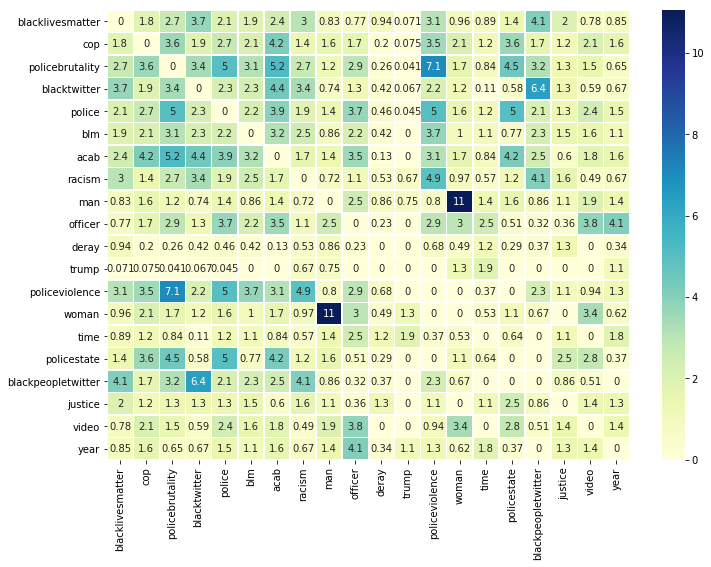

In [138]:
# HeatMap
import numpy as np 
from pandas import DataFrame
import seaborn as sns

%matplotlib inline
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27


dflift2 = dflift.replace(np.nan, 0)
sns.heatmap(dflift2, annot=True, linewidths=.5, cmap="YlGnBu")

## Topic Modeling

In [19]:
# Create dataframe according to account types
df_right = data[data['account_category'] == 'RightTroll']['no_stop'].apply(lemmatize_stem_text)
df_left = data[data['account_category'] == 'LeftTroll']['no_stop'].apply(lemmatize_stem_text)

In [163]:
#Bag of Words on the RightTroll category data
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
dictionary_right = gensim.corpora.Dictionary(df_right)
count = 0
for k, v in dictionary_right.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 barely
1 corruption
2 democrat
3 heard
4 httpstcogh6g0d1oic
5 mainstream
6 medium
7 nedryun
8 peep
9 senator
10 sitting


In [165]:
#Bag of Words on the LeftTroll category data
dictionary_left = gensim.corpora.Dictionary(df_left)
count = 0
for k, v in dictionary_left.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 blacklivesmatter
1 blm
2 equality
3 equalrights
4 httpstcoikjxvxtmjz
5 bigguninutah
6 pay
7 right
8 tax
9 work
10 25


In [173]:
#Filter out tokens that appear
dictionary_right.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
dictionary_left.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

#Gensim doc2bow
bow_corpus_right = [dictionary_right.doc2bow(doc) for doc in df_right]
bow_corpus_left= [dictionary_left.doc2bow(doc) for doc in df_left]

In [176]:
#Running LDA using Bag of Words for RightTroll
lda_model = gensim.models.LdaMulticore(bow_corpus_right, num_topics=3, id2word=dictionary_right, passes=50)
ids = []
topics = []
for idx, topic in lda_model.print_topics(-1):
    ids.append(idx)
    topics.append(topic)
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.380*"trump" + 0.203*"president" + 0.167*"realdonaldtrump" + 0.104*"cnn" + 0.080*"hillary" + 0.055*"say" + 0.004*"police" + 0.001*"dont" + 0.001*"great" + 0.001*"people"
Topic: 1 
Words: 0.409*"people" + 0.391*"islamkills" + 0.099*"dont" + 0.051*"say" + 0.006*"great" + 0.006*"president" + 0.006*"trump" + 0.006*"realdonaldtrump" + 0.006*"hillary" + 0.006*"cnn"
Topic: 2 
Words: 0.276*"great" + 0.263*"vegasgopdebate" + 0.254*"police" + 0.167*"dont" + 0.006*"realdonaldtrump" + 0.006*"trump" + 0.005*"people" + 0.005*"president" + 0.005*"hillary" + 0.005*"say"


In [178]:
#Running LDA using Bag of Words for LeftTroll
lda_model1 = gensim.models.LdaMulticore(bow_corpus_left, num_topics=3, id2word=dictionary_left, passes=50)
ids = []
topics = []
for idx, topic in lda_model1.print_topics(-1):
    ids.append(idx)
    topics.append(topic)
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.056*"cop" + 0.037*"police" + 0.026*"man" + 0.024*"like" + 0.019*"officer" + 0.018*"get" + 0.016*"say" + 0.015*"shaunking" + 0.015*"dont" + 0.015*"people"
Topic: 1 
Words: 0.159*"blacklivesmatter" + 0.091*"policebrutality" + 0.066*"cop" + 0.057*"blacktwitter" + 0.042*"acab" + 0.042*"blm" + 0.031*"racism" + 0.029*"staywoke" + 0.027*"police" + 0.019*"policeabuse"
Topic: 2 
Words: 0.027*"white" + 0.025*"deray" + 0.024*"black" + 0.019*"im" + 0.018*"reverantrevan" + 0.017*"4mysquad" + 0.017*"right" + 0.016*"one" + 0.016*"racist" + 0.015*"u"


## Sentiment Analysis

In [6]:
# Create dataframe according to account types
df_r = data[data['account_category'] == 'RightTroll']
df_l = data[data['account_category'] == 'LeftTroll']
df_g = data[data['account_category'] == 'HashtagGamer']
df_n = data[data['account_category'] == 'NewsFeed']

In [12]:
import pandas as pd
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
import numpy as np
import nltk
nltk.download('movie_reviews')

def word_feats(words):
    return dict([(word, True) for word in words])

negids = movie_reviews.fileids('neg')
posids = movie_reviews.fileids('pos')
 
negfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in negids]
posfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in posids]

trainfeats = negfeats + posfeats
 
classifier = NaiveBayesClassifier.train(trainfeats)

df_r['sentiment_right'] = df_r['no_stop'].apply(lemmatize_stem_text).apply(lambda x: classifier.prob_classify(word_feats(x)).prob('pos') - classifier.prob_classify(word_feats(x)).prob('neg'))
df_l['sentiment_left'] = df_l['no_stop'].apply(lemmatize_stem_text).apply(lambda x: classifier.prob_classify(word_feats(x)).prob('pos') - classifier.prob_classify(word_feats(x)).prob('neg'))
df_g['sentiment_gamer'] = df_g['no_stop'].apply(lemmatize_stem_text).apply(lambda x: classifier.prob_classify(word_feats(x)).prob('pos') - classifier.prob_classify(word_feats(x)).prob('neg'))
df_n['sentiment_news'] = df_n['no_stop'].apply(lemmatize_stem_text).apply(lambda x: classifier.prob_classify(word_feats(x)).prob('pos') - classifier.prob_classify(word_feats(x)).prob('neg'))

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/YixuanDu/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
grouped_r = df_r.groupby(['author'])
y = grouped_r.sentiment_right.aggregate(np.sum)

grouped_l = df_l.groupby(['author'])
x = grouped_l.sentiment_left.aggregate(np.sum)

grouped_g = df_g.groupby(['author'])
z = grouped_g.sentiment_gamer.aggregate(np.sum)

grouped_n = df_n.groupby(['author'])
s = grouped_n.sentiment_news.aggregate(np.sum)

combined = pd.concat([y,x,z,s],axis=1)
combined
# NaN means the author doesn't belong to certain account categories

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  del sys.path[0]


,sentiment_right,sentiment_left,sentiment_gamer,sentiment_news
10_GOP,68.160779,NaN,NaN,NaN
1ERIK_LEE,0.290990,NaN,NaN,NaN
2NDHALFONION,1.882324,NaN,NaN,NaN
4EVER_SUSAN,-5.324936,NaN,NaN,NaN
4MYSQUAD,NaN,222.23303,NaN,NaN
